In [1]:
import pandas as pd

# Load Excel file
file_path = "Sustainable Data.xlsx"   # replace with your file path
df = pd.read_excel(file_path)
cols_to_drop = ['FoodwastePermittedLimit(MT','Percentage difference']
df = df.drop(columns=cols_to_drop)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2158 entries, 0 to 2157
Columns: 152 entries, month to gridEmissionNew
dtypes: float64(96), int64(3), object(53)
memory usage: 2.5+ MB


In [2]:
def nullCols(df,x):
    print("--- Count of Null Values in Each Column ---")
    null_counts = df.isnull().sum()
    display(null_counts[null_counts >x].sort_values(ascending=False))
    print(null_counts[null_counts >x].index)

def nullColsVis(df):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Function to get bad columns for each year
    def get_null_or_zero_cols(group):
        bad_cols = group.columns[(group.isna().all()) | ((group == 0).all())].tolist()
        return pd.Series({
            "num_columns": len(bad_cols),
            "columns": bad_cols
        })

    # Apply function per year
    col_info_by_year = df.groupby("year").apply(get_null_or_zero_cols).reset_index()

    # Print results
    for _, row in col_info_by_year.iterrows():
        print(f"\nYear: {row['year']}")
        print(f"Number of completely null/zero columns: {row['num_columns']}")
        print(f"Columns: {row['columns']}")

    # Visualization
    plt.figure(figsize=(8,5))
    plt.bar(col_info_by_year["year"], col_info_by_year["num_columns"])
    plt.xlabel("Year")
    plt.ylabel("Columns completely null or 0")
    plt.title("Completely null/zero columns per year")
    plt.show()

def nullZero(df):
    null_counts = df.isna().sum()
    zero_counts = (df == 0).sum()
    counts = pd.DataFrame({
        "Null Count": null_counts,
        "Zero Count": zero_counts,
    })

    print(counts[counts['Zero Count']>0].index)

In [3]:
col=['month', 'Current Date', 'Plant Name', 'Plant Name: organisation',
       'quarter', 'year', 'financialYear', 'Scope1', 'Scope_2',
       'totalEnergyPerUnit(GJ)', 'TotalCO2emission(MT)',
       'Electricity Grid Energy Per Unit (GJ)',
       'Electricity Grid TCO2 Emission',
       'Production Actual Quantity (MT/Month)', 'totalWaterConsumption',
       'Attachments', 'Plant Location', 'gridEmissionTesting',
       'Plant Name: category']
dfAll=df[col]

In [4]:
col = "Production Actual Quantity (MT/Month)"
dfAll[col] = dfAll[col].fillna(dfAll[col].mean())

/var/folders/t9/jw8v20856t3c_21v8gyprxlm0000gn/T/ipykernel_19370/2824078700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfAll[col] = dfAll[col].fillna(dfAll[col].mean())


In [5]:
nullCols(dfAll,0)
nullZero(dfAll)

--- Count of Null Values in Each Column ---


Series([], dtype: int64)

Index([], dtype='object')
Index(['Scope1', 'Scope_2', 'totalEnergyPerUnit(GJ)', 'TotalCO2emission(MT)',
       'Electricity Grid Energy Per Unit (GJ)',
       'Electricity Grid TCO2 Emission',
       'Production Actual Quantity (MT/Month)', 'totalWaterConsumption',
       'Attachments', 'gridEmissionTesting'],
      dtype='object')


In [6]:
import numpy as np
col2=['Scope1', 'Scope_2', 'totalEnergyPerUnit(GJ)', 'TotalCO2emission(MT)',
       'Electricity Grid Energy Per Unit (GJ)',
       'Electricity Grid TCO2 Emission',
       'Production Actual Quantity (MT/Month)', 'totalWaterConsumption',
       'Attachments', 'gridEmissionTesting']
for col in col2:
    dfAll[col] = dfAll[col].replace(0, np.nan).fillna(dfAll[col].mean())

/var/folders/t9/jw8v20856t3c_21v8gyprxlm0000gn/T/ipykernel_19370/1517644482.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfAll[col] = dfAll[col].replace(0, np.nan).fillna(dfAll[col].mean())


In [7]:
# ===== 0) Imports =====
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# ===== 1) CONFIG =====
DATE_COL = "Current Date"                       # if missing/dirty, we’ll rebuild from year & month
TARGET_COL = "TotalCO2emission(MT)"             # the series to forecast
PLANT_COL = "Plant Name"                        # per-plant option
FORECAST_MONTHS = 6                            # horizon
TEST_MONTHS = 12                                 # last N months as test

# ===== 2) START FROM df_2020 =====
# Assumes df_2020 exists in memory with the structure you shared.
df = dfAll.copy()

# ----- 2a) Ensure a proper datetime column 'ds' -----
if DATE_COL in df.columns:
    # Try parsing; if parsing fails for some rows, we rebuild ds below
    ds = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True, infer_datetime_format=True)
else:
    ds = pd.Series(pd.NaT, index=df.index)

# If ds has NaT (or 'Current Date' missing), rebuild from year+month (set day=1)
needs_rebuild = ds.isna()
if needs_rebuild.any():
    if not {"year", "month"}.issubset(df.columns):
        raise ValueError("No valid 'Current Date' and missing 'year'/'month' to rebuild dates.")
    ds_rebuilt = pd.to_datetime(
        dict(year=df.loc[needs_rebuild, "year"],
             month=df.loc[needs_rebuild, "month"],
             day=1)
    )
    ds.loc[needs_rebuild] = ds_rebuilt

df["ds"] = pd.to_datetime(ds).dt.to_period("M").dt.to_timestamp()  # normalize to month-start

# ----- 2b) Basic cleaning: drop obvious duplicates, keep consistent types -----
df = df.drop_duplicates(subset=["ds", PLANT_COL, TARGET_COL], keep="last")

# ----- 2c) Impute zeros/NaNs with mean for all numeric columns (by year, then global fallback) -----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def impute_zero_nan_with_mean(group: pd.DataFrame) -> pd.DataFrame:
    # Replace 0 with NaN, then fill with column mean (within group)
    g = group.copy()
    for c in num_cols:
        g[c] = g[c].replace(0, np.nan)
        if g[c].notna().any():
            g[c] = g[c].fillna(g[c].mean())
    return g

# First try imputation within each calendar year (if present)
if "year" in df.columns:
    df = df.groupby("year", group_keys=False).apply(impute_zero_nan_with_mean)
else:
    df = impute_zero_nan_with_mean(df)

# Global fallback (in case an entire year's column was all zeros/NaN)
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

# ===== 3) TWO PATHS: (A) OVERALL monthly forecast across all plants, (B) PER-PLANT forecasts =====

# ---------- A) OVERALL SERIES ----------
def prepare_overall_series(df_in: pd.DataFrame) -> pd.DataFrame:
    # Aggregate monthly across plants (sum is typical for emissions; use 'mean' if you prefer)
    s = (df_in
         .groupby("ds", as_index=False)[TARGET_COL]
         .sum()
         .sort_values("ds"))
    s = s.rename(columns={TARGET_COL: "y"})
    return s

overall = prepare_overall_series(df)

# Train / Test split by last TEST_MONTHS
overall = overall.sort_values("ds").reset_index(drop=True)
split_point = len(overall) - TEST_MONTHS if len(overall) > TEST_MONTHS else len(overall)
train_overall = overall.iloc[:split_point].copy()
test_overall = overall.iloc[split_point:].copy()  # may be empty if not enough months

# Fit Prophet (no extra regressors for the baseline)
m_overall = Prophet(seasonality_mode="additive", yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_overall.fit(train_overall)

# In-sample forecast to last training date (+ test window to compare)
future_cutoff = train_overall["ds"].max()
future_all = m_overall.make_future_dataframe(periods=max(TEST_MONTHS, 0), freq="MS")
fcst_all = m_overall.predict(future_all)

# Evaluate on test if available
if not test_overall.empty:
    # Align predictions with actual test months
    y_pred = (fcst_all[["ds", "yhat"]]
              .merge(test_overall[["ds", "y"]], on="ds", how="inner"))
    mape_overall = mean_absolute_percentage_error(y_pred["y"], y_pred["yhat"])
else:
    mape_overall = np.nan

# Final 12-month forecast (beyond the full available data)
future_12 = m_overall.make_future_dataframe(periods=FORECAST_MONTHS, freq="MS")
forecast_12 = m_overall.predict(future_12).loc[:, ["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_12 = forecast_12[forecast_12["ds"] > overall["ds"].max()].reset_index(drop=True)

print("=== OVERALL SERIES ===")
print(f"Training months: {len(train_overall)} | Test months: {len(test_overall)}")
print(f"Overall Test MAPE: {mape_overall:.3f}" if not np.isnan(mape_overall) else "Overall Test MAPE: N/A (not enough test months)")
print("\nNext 12 months forecast (overall):")
print(forecast_12)

# ---------- B) PER-PLANT SERIES (optional) ----------
# Build one model per plant; returns a dict of {plant: (mape, forecast_df)}
def forecast_per_plant(df_in: pd.DataFrame, test_months: int = 3, horizon: int = 12):
    out = {}
    g = (df_in.groupby([PLANT_COL, "ds"], as_index=False)[TARGET_COL]
         .sum()
         .rename(columns={TARGET_COL: "y"}))

    for plant, gdf in g.groupby(PLANT_COL):
        gdf = gdf.sort_values("ds").reset_index(drop=True)
        if len(gdf) < 6:
            out[plant] = (np.nan, pd.DataFrame())
            continue

        split = len(gdf) - test_months if len(gdf) > test_months else len(gdf)
        train = gdf.iloc[:split].copy()
        test  = gdf.iloc[split:].copy()

        m = Prophet(seasonality_mode="additive", yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(train)

        future_all = m.make_future_dataframe(periods=max(test_months, 0), freq="MS")
        fcst_all  = m.predict(future_all)

        # Align test and predictions
        y_pred = (fcst_all[["ds", "yhat"]]
                  .merge(test[["ds", "y"]], on="ds", how="inner"))

        if not test.empty and not y_pred.empty:
            mape = mean_absolute_percentage_error(y_pred["y"], y_pred["yhat"])
        else:
            mape = np.nan   # No overlap, can’t compute MAPE

        future_h = m.make_future_dataframe(periods=horizon, freq="MS")
        fcst_h = m.predict(future_h)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
        fcst_h = fcst_h[fcst_h["ds"] > gdf["ds"].max()].reset_index(drop=True)

        out[plant] = (mape, fcst_h)

    return out


# Run per-plant (optional; comment this block if you only need overall)
per_plant_results = forecast_per_plant(df, test_months=TEST_MONTHS, horizon=FORECAST_MONTHS)

# Show a quick summary table for per-plant MAPE
per_plant_mape = pd.DataFrame(
    [(plant, mape) for plant, (mape, _) in per_plant_results.items()],
    columns=[PLANT_COL, "Test MAPE"]
).sort_values("Test MAPE", na_position="last")
print("\n=== PER-PLANT MAPE (lower is better) ===")
print(per_plant_mape.head(20))  # top 20; adjust as needed




21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing


=== OVERALL SERIES ===
Training months: 39 | Test months: 12
Overall Test MAPE: 28.444

Next 12 months forecast (overall):
Empty DataFrame
Columns: [ds, yhat, yhat_lower, yhat_upper]
Index: []


21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1]


=== PER-PLANT MAPE (lower is better) ===
         Plant Name  Test MAPE
46            Yoloo   2.149336
32    U-10, Tarapur   3.678006
41    U-5, Jhagadia   4.119387
35  U-2, Ankleshwar   4.338471
6         Canelands   4.622296
14         La Palma   5.297164
42      U-51, Kalol   5.674763
21   NPP, Bangalore   6.467882
4          Bien Hoa   6.474294
44      U-9, Haldia   7.830281
43       U-8, Jammu   8.782200
30        U-0, Vapi   9.072127
9        Derdepoort   9.609693
33      U-12, Dahej   9.910499
38  U-3, Ankleshwar  10.090253
17           Madrid  11.135812
8           Chungju  11.722936
0            Abbott  11.769453
13        Kingstree  13.025887
16     Liège Ougree  13.767952


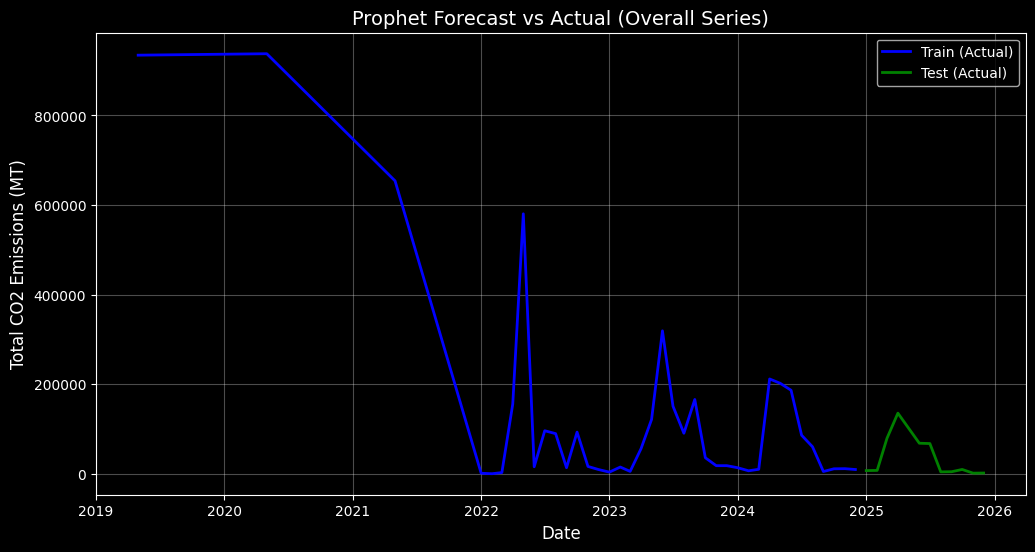

In [8]:
import matplotlib.pyplot as plt

# Align predictions with full actuals
eval_df = (fcst_all[["ds", "yhat"]]
           .merge(overall[["ds", "y"]], on="ds", how="left"))

plt.figure(figsize=(12,6))

# A) Train actuals
plt.plot(train_overall['ds'], train_overall['y'],
         label="Train (Actual)", linewidth=2, color="blue")

# B) Test actuals
plt.plot(test_overall['ds'], test_overall['y'],
         label="Test (Actual)", linewidth=2, color="green")

# # C) Prophet forecast (fitted + on test window)
# plt.plot(eval_df['ds'], eval_df['yhat'],
#          '--', label="Forecast (Prophet)", linewidth=2, color="red")

# # D) Train/Test split marker
# if not test_overall.empty:
#     split_date = test_overall['ds'].min()
#     plt.axvline(split_date, color='gray', linestyle='--',
#                 linewidth=2, label="Train/Test Split")

# Titles and labels
plt.title("Prophet Forecast vs Actual (Overall Series)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total CO2 Emissions (MT)", fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


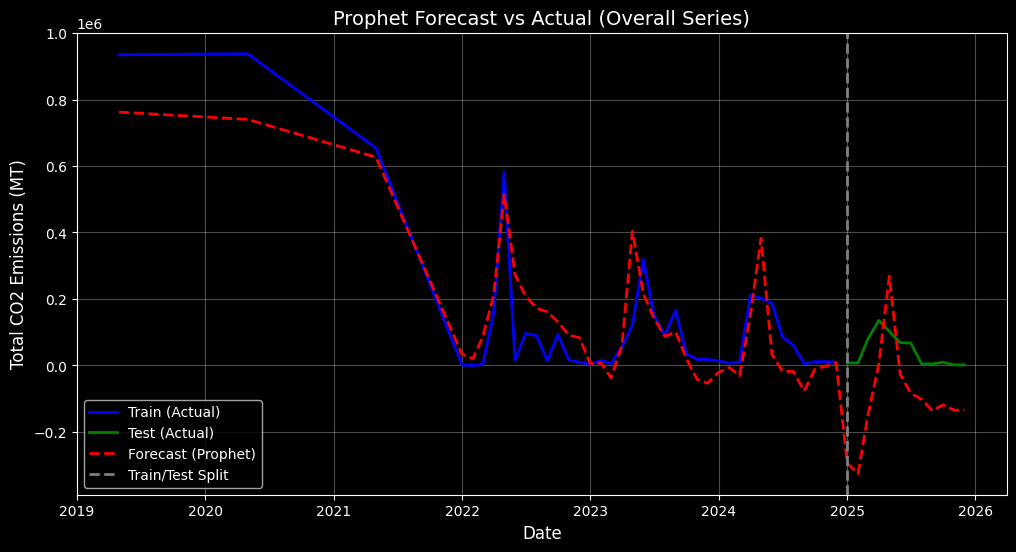

In [9]:
import matplotlib.pyplot as plt

# Align predictions with full actuals
eval_df = (fcst_all[["ds", "yhat"]]
           .merge(overall[["ds", "y"]], on="ds", how="left"))

plt.figure(figsize=(12,6))

# A) Train actuals
plt.plot(train_overall['ds'], train_overall['y'],
         label="Train (Actual)", linewidth=2, color="blue")

# B) Test actuals
plt.plot(test_overall['ds'], test_overall['y'],
         label="Test (Actual)", linewidth=2, color="green")

# C) Prophet forecast (fitted + on test window)
plt.plot(eval_df['ds'], eval_df['yhat'],
         '--', label="Forecast (Prophet)", linewidth=2, color="red")

# D) Train/Test split marker
if not test_overall.empty:
    split_date = test_overall['ds'].min()
    plt.axvline(split_date, color='gray', linestyle='--',
                linewidth=2, label="Train/Test Split")

# Titles and labels
plt.title("Prophet Forecast vs Actual (Overall Series)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total CO2 Emissions (MT)", fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 2022

In [10]:

df_2022=df.copy(deep=True)
df_2022=df_2022[df_2022['year']>=2022]

In [11]:
temp=df_2022[df_2022['year']>=2022]
print(temp.shape)
print("--- Count of Null Values in Each Column ---")

null_counts = temp.isnull().sum()
display(null_counts[null_counts >0].sort_values(ascending=False))
print(null_counts[null_counts >0].index.tolist())

(1719, 20)
--- Count of Null Values in Each Column ---


Series([], dtype: int64)

[]


In [12]:
col = "Production Actual Quantity (MT/Month)"
df_2022[col] = df_2022[col].fillna(df_2022[col].mean())

In [13]:
def nullZero(df):
    null_counts = df_2022.isna().sum()
    zero_counts = (df_2022 == 0).sum()
    counts = pd.DataFrame({
        "Null Count": null_counts,
        "Zero Count": zero_counts,
    })

    print(counts[counts['Zero Count']>0].index)

In [14]:
import numpy as np
col2=['Scope1', 'Scope_2', 'totalEnergyPerUnit(GJ)', 'TotalCO2emission(MT)',
       'Electricity Grid Energy Per Unit (GJ)',
       'Electricity Grid TCO2 Emission',
       'Production Actual Quantity (MT/Month)', 'totalWaterConsumption',
       'Attachments', 'gridEmissionTesting']
for col in col2:
    df_2022[col] = df_2022[col].replace(0, np.nan).fillna(df_2022[col].mean())


In [15]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1719 entries, 438 to 2157
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   month                                  1719 non-null   int64         
 1   Current Date                           1719 non-null   object        
 2   Plant Name                             1719 non-null   object        
 3   Plant Name: organisation               1719 non-null   object        
 4   quarter                                1719 non-null   object        
 5   year                                   1719 non-null   int64         
 6   financialYear                          1719 non-null   object        
 7   Scope1                                 1719 non-null   float64       
 8   Scope_2                                1719 non-null   float64       
 9   totalEnergyPerUnit(GJ)                 1719 non-null   float64    

In [16]:
# ===== 0) Imports =====
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# ===== 1) CONFIG =====
DATE_COL = "Current Date"                       # if missing/dirty, we’ll rebuild from year & month
TARGET_COL = "TotalCO2emission(MT)"             # the series to forecast
PLANT_COL = "Plant Name"                        # per-plant option
FORECAST_MONTHS = 6                            # horizon
TEST_MONTHS = 12                                 # last N months as test

# ===== 2) START FROM df_2020 =====
# Assumes df_2020 exists in memory with the structure you shared.
df = df_2022.copy()

# ----- 2a) Ensure a proper datetime column 'ds' -----
if DATE_COL in df.columns:
    # Try parsing; if parsing fails for some rows, we rebuild ds below
    ds = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True, infer_datetime_format=True)
else:
    ds = pd.Series(pd.NaT, index=df.index)

# If ds has NaT (or 'Current Date' missing), rebuild from year+month (set day=1)
needs_rebuild = ds.isna()
if needs_rebuild.any():
    if not {"year", "month"}.issubset(df.columns):
        raise ValueError("No valid 'Current Date' and missing 'year'/'month' to rebuild dates.")
    ds_rebuilt = pd.to_datetime(
        dict(year=df.loc[needs_rebuild, "year"],
             month=df.loc[needs_rebuild, "month"],
             day=1)
    )
    ds.loc[needs_rebuild] = ds_rebuilt

df["ds"] = pd.to_datetime(ds).dt.to_period("M").dt.to_timestamp()  # normalize to month-start

# ----- 2b) Basic cleaning: drop obvious duplicates, keep consistent types -----
df = df.drop_duplicates(subset=["ds", PLANT_COL, TARGET_COL], keep="last")

# ----- 2c) Impute zeros/NaNs with mean for all numeric columns (by year, then global fallback) -----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def impute_zero_nan_with_mean(group: pd.DataFrame) -> pd.DataFrame:
    # Replace 0 with NaN, then fill with column mean (within group)
    g = group.copy()
    for c in num_cols:
        g[c] = g[c].replace(0, np.nan)
        if g[c].notna().any():
            g[c] = g[c].fillna(g[c].mean())
    return g

# First try imputation within each calendar year (if present)
if "year" in df.columns:
    df = df.groupby("year", group_keys=False).apply(impute_zero_nan_with_mean)
else:
    df = impute_zero_nan_with_mean(df)

# Global fallback (in case an entire year's column was all zeros/NaN)
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

# ===== 3) TWO PATHS: (A) OVERALL monthly forecast across all plants, (B) PER-PLANT forecasts =====

# ---------- A) OVERALL SERIES ----------
def prepare_overall_series(df_in: pd.DataFrame) -> pd.DataFrame:
    # Aggregate monthly across plants (sum is typical for emissions; use 'mean' if you prefer)
    s = (df_in
         .groupby("ds", as_index=False)[TARGET_COL]
         .sum()
         .sort_values("ds"))
    s = s.rename(columns={TARGET_COL: "y"})
    return s

overall = prepare_overall_series(df)

# Train / Test split by last TEST_MONTHS
overall = overall.sort_values("ds").reset_index(drop=True)
split_point = len(overall) - TEST_MONTHS if len(overall) > TEST_MONTHS else len(overall)
train_overall = overall.iloc[:split_point].copy()
test_overall = overall.iloc[split_point:].copy()  # may be empty if not enough months

# Fit Prophet (no extra regressors for the baseline)
m_overall = Prophet(seasonality_mode="additive", yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_overall.fit(train_overall)

# In-sample forecast to last training date (+ test window to compare)
future_cutoff = train_overall["ds"].max()
future_all = m_overall.make_future_dataframe(periods=max(TEST_MONTHS, 0), freq="MS")
fcst_all = m_overall.predict(future_all)

# Evaluate on test if available
if not test_overall.empty:
    # Align predictions with actual test months
    y_pred = (fcst_all[["ds", "yhat"]]
              .merge(test_overall[["ds", "y"]], on="ds", how="inner"))
    mape_overall = mean_absolute_percentage_error(y_pred["y"], y_pred["yhat"])
else:
    mape_overall = np.nan

# Final 12-month forecast (beyond the full available data)
future_12 = m_overall.make_future_dataframe(periods=FORECAST_MONTHS, freq="MS")
forecast_12 = m_overall.predict(future_12).loc[:, ["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_12 = forecast_12[forecast_12["ds"] > overall["ds"].max()].reset_index(drop=True)

print("=== OVERALL SERIES ===")
print(f"Training months: {len(train_overall)} | Test months: {len(test_overall)}")
print(f"Overall Test MAPE: {mape_overall:.3f}" if not np.isnan(mape_overall) else "Overall Test MAPE: N/A (not enough test months)")
print("\nNext 12 months forecast (overall):")
print(forecast_12)

# ---------- B) PER-PLANT SERIES (optional) ----------
# Build one model per plant; returns a dict of {plant: (mape, forecast_df)}
def forecast_per_plant(df_in: pd.DataFrame, test_months: int = 3, horizon: int = 12):
    out = {}
    g = (df_in.groupby([PLANT_COL, "ds"], as_index=False)[TARGET_COL]
         .sum()
         .rename(columns={TARGET_COL: "y"}))

    for plant, gdf in g.groupby(PLANT_COL):
        gdf = gdf.sort_values("ds").reset_index(drop=True)
        if len(gdf) < 6:
            out[plant] = (np.nan, pd.DataFrame())
            continue

        split = len(gdf) - test_months if len(gdf) > test_months else len(gdf)
        train = gdf.iloc[:split].copy()
        test  = gdf.iloc[split:].copy()

        m = Prophet(seasonality_mode="additive", yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(train)

        future_all = m.make_future_dataframe(periods=max(test_months, 0), freq="MS")
        fcst_all  = m.predict(future_all)

        # Align test and predictions
        y_pred = (fcst_all[["ds", "yhat"]]
                  .merge(test[["ds", "y"]], on="ds", how="inner"))

        if not test.empty and not y_pred.empty:
            mape = mean_absolute_percentage_error(y_pred["y"], y_pred["yhat"])
        else:
            mape = np.nan   # No overlap, can’t compute MAPE

        future_h = m.make_future_dataframe(periods=horizon, freq="MS")
        fcst_h = m.predict(future_h)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
        fcst_h = fcst_h[fcst_h["ds"] > gdf["ds"].max()].reset_index(drop=True)

        out[plant] = (mape, fcst_h)

    return out


# Run per-plant (optional; comment this block if you only need overall)
per_plant_results = forecast_per_plant(df, test_months=TEST_MONTHS, horizon=FORECAST_MONTHS)

# Show a quick summary table for per-plant MAPE
per_plant_mape = pd.DataFrame(
    [(plant, mape) for plant, (mape, _) in per_plant_results.items()],
    columns=[PLANT_COL, "Test MAPE"]
).sort_values("Test MAPE", na_position="last")
print("\n=== PER-PLANT MAPE (lower is better) ===")
print(per_plant_mape.head(20))  # top 20; adjust as needed




21:49:49 - cmdstanpy - INFO - Chain [1] start processing
21:49:49 - cmdstanpy - INFO - Chain [1] done processing


=== OVERALL SERIES ===
Training months: 36 | Test months: 12
Overall Test MAPE: 4.084

Next 12 months forecast (overall):
Empty DataFrame
Columns: [ds, yhat, yhat_lower, yhat_upper]
Index: []


21:49:49 - cmdstanpy - INFO - Chain [1] start processing
21:49:50 - cmdstanpy - INFO - Chain [1] done processing
21:49:50 - cmdstanpy - INFO - Chain [1] start processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] start processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] start processing
21:49:51 - cmdstanpy - INFO - Chain [1] done processing
21:49:51 - cmdstanpy - INFO - Chain [1] start processing
21:49:53 - cmdstanpy - INFO - Chain [1] done processing
21:49:53 - cmdstanpy - INFO - Chain [1] start processing
21:50:00 - cmdstanpy - INFO - Chain [1] done processing
21:50:00 - cmdstanpy - INFO - Chain [1] start processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing
21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:02 - cmdstanpy - INFO - Chain [1] done processing
21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1]


=== PER-PLANT MAPE (lower is better) ===
          Plant Name  Test MAPE
13          La Palma   1.246902
14          Le Canet   1.700650
39     U-5, Jhagadia   2.646556
12         Kingstree   2.758414
30     U-10, Tarapur   3.192897
16            Madrid   3.823347
5            Bioquim   4.028538
27             Tevsa   4.521334
28         U-0, Vapi   5.129221
0             Abbott   5.478502
35  U-26, Ankleshwar   5.741910
23      Ramos Arizpe   6.170356
7           Chaillac   6.215148
20    NPP, Bangalore   6.467882
44             Yoloo   7.471860
29   U-1, Ankleshwar   7.529479
22               Pau   8.841380
25          Sandbach   8.847201
36   U-3, Ankleshwar   9.460320
26          St. Malo   9.928805


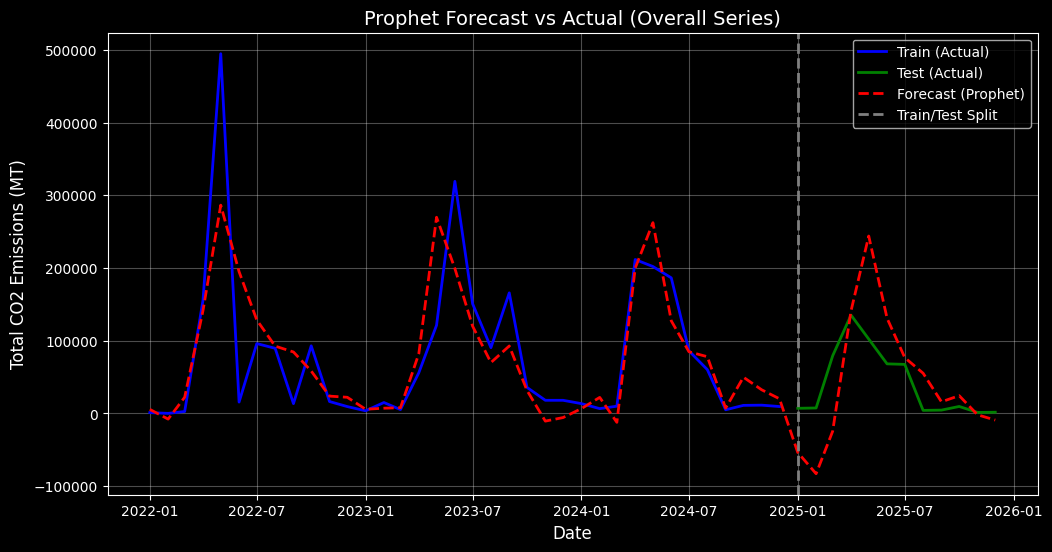

In [17]:
import matplotlib.pyplot as plt

# Align predictions with full actuals
eval_df = (fcst_all[["ds", "yhat"]]
           .merge(overall[["ds", "y"]], on="ds", how="left"))

plt.figure(figsize=(12,6))

# A) Train actuals
plt.plot(train_overall['ds'], train_overall['y'],
         label="Train (Actual)", linewidth=2, color="blue")

# B) Test actuals
plt.plot(test_overall['ds'], test_overall['y'],
         label="Test (Actual)", linewidth=2, color="green")

# C) Prophet forecast (fitted + on test window)
plt.plot(eval_df['ds'], eval_df['yhat'],
         '--', label="Forecast (Prophet)", linewidth=2, color="red")

# D) Train/Test split marker
if not test_overall.empty:
    split_date = test_overall['ds'].min()
    plt.axvline(split_date, color='gray', linestyle='--',
                linewidth=2, label="Train/Test Split")

# Titles and labels
plt.title("Prophet Forecast vs Actual (Overall Series)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total CO2 Emissions (MT)", fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


21:58:10 - cmdstanpy - INFO - Chain [1] start processing
21:58:10 - cmdstanpy - INFO - Chain [1] done processing


=== OVERALL SERIES ===
Training months: 36 | Test months: 12
Overall Test MAPE: 4.084


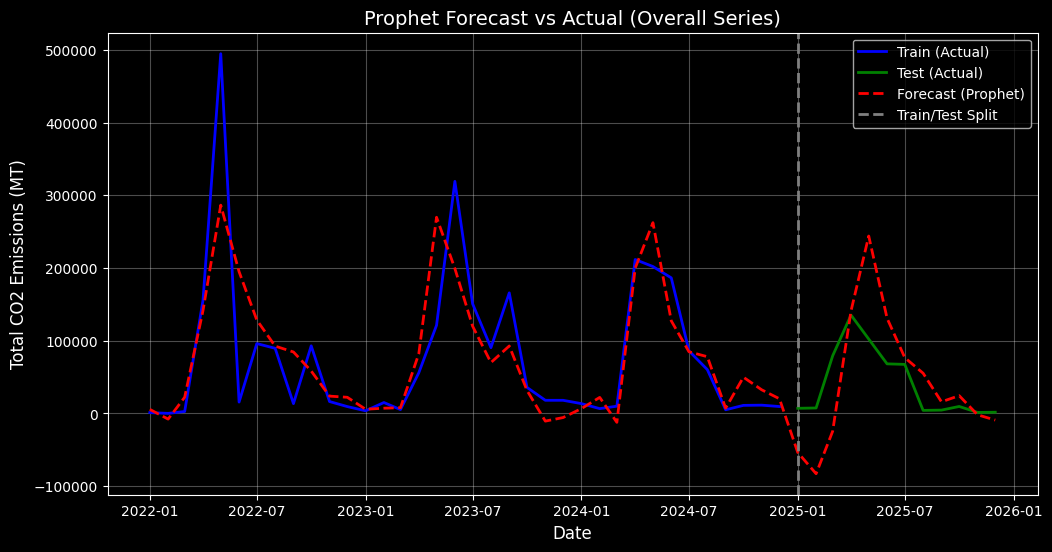

In [24]:
# ===== 0) Imports =====
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# ===== 1) CONFIG =====
DATE_COL = "Current Date"                       # if missing/dirty, we’ll rebuild from year & month
TARGET_COL = "TotalCO2emission(MT)"             # the series to forecast
PLANT_COL = "Plant Name"                        # per-plant option
FORECAST_MONTHS = 12                            # horizon
TEST_MONTHS = 12                                 # last N months as test

# ===== 2) START FROM df_2020 =====
# Assumes df_2020 exists in memory with the structure you shared.
df = df_2022.copy()

# ----- 2a) Ensure a proper datetime column 'ds' -----
if DATE_COL in df.columns:
    # Try parsing; if parsing fails for some rows, we rebuild ds below
    ds = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True, infer_datetime_format=True)
else:
    ds = pd.Series(pd.NaT, index=df.index)

# If ds has NaT (or 'Current Date' missing), rebuild from year+month (set day=1)
needs_rebuild = ds.isna()
if needs_rebuild.any():
    if not {"year", "month"}.issubset(df.columns):
        raise ValueError("No valid 'Current Date' and missing 'year'/'month' to rebuild dates.")
    ds_rebuilt = pd.to_datetime(
        dict(year=df.loc[needs_rebuild, "year"],
             month=df.loc[needs_rebuild, "month"],
             day=1)
    )
    ds.loc[needs_rebuild] = ds_rebuilt

df["ds"] = pd.to_datetime(ds).dt.to_period("M").dt.to_timestamp()  # normalize to month-start

# ----- 2b) Basic cleaning: drop obvious duplicates, keep consistent types -----
df = df.drop_duplicates(subset=["ds", PLANT_COL, TARGET_COL], keep="last")

# ----- 2c) Impute zeros/NaNs with mean for all numeric columns (by year, then global fallback) -----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def impute_zero_nan_with_mean(group: pd.DataFrame) -> pd.DataFrame:
    # Replace 0 with NaN, then fill with column mean (within group)
    g = group.copy()
    for c in num_cols:
        g[c] = g[c].replace(0, np.nan)
        if g[c].notna().any():
            g[c] = g[c].fillna(g[c].mean())
    return g

# First try imputation within each calendar year (if present)
if "year" in df.columns:
    df = df.groupby("year", group_keys=False).apply(impute_zero_nan_with_mean)
else:
    df = impute_zero_nan_with_mean(df)

# Global fallback (in case an entire year's column was all zeros/NaN)
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

# ===== 3) TWO PATHS: (A) OVERALL monthly forecast across all plants, (B) PER-PLANT forecasts =====

# ---------- A) OVERALL SERIES ----------
def prepare_overall_series(df_in: pd.DataFrame) -> pd.DataFrame:
    # Aggregate monthly across plants (sum is typical for emissions; use 'mean' if you prefer)
    s = (df_in
         .groupby("ds", as_index=False)[TARGET_COL]
         .sum()
         .sort_values("ds"))
    s = s.rename(columns={TARGET_COL: "y"})
    return s

overall = prepare_overall_series(df)

# Train / Test split by last TEST_MONTHS
overall = overall.sort_values("ds").reset_index(drop=True)
split_point = len(overall) - TEST_MONTHS if len(overall) > TEST_MONTHS else len(overall)
train_overall = overall.iloc[:split_point].copy()
test_overall = overall.iloc[split_point:].copy()  # may be empty if not enough months

# Fit Prophet (no extra regressors for the baseline)
m_overall = Prophet(seasonality_mode="additive", yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_overall.fit(train_overall)

# In-sample forecast to last training date (+ test window to compare)
future_cutoff = train_overall["ds"].max()
future_all = m_overall.make_future_dataframe(periods=max(TEST_MONTHS, 0), freq="MS")
fcst_all = m_overall.predict(future_all)

# Evaluate on test if available
if not test_overall.empty:
    # Align predictions with actual test months
    y_pred = (fcst_all[["ds", "yhat"]]
              .merge(test_overall[["ds", "y"]], on="ds", how="inner"))
    mape_overall = mean_absolute_percentage_error(y_pred["y"], y_pred["yhat"])
else:
    mape_overall = np.nan

# Final 12-month forecast (beyond the full available data)
future_12 = m_overall.make_future_dataframe(periods=FORECAST_MONTHS, freq="MS")
forecast_12 = m_overall.predict(future_12).loc[:, ["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_12 = forecast_12[forecast_12["ds"] > overall["ds"].max()].reset_index(drop=True)
print("=== OVERALL SERIES ===")
print(f"Training months: {len(train_overall)} | Test months: {len(test_overall)}")
print(f"Overall Test MAPE: {mape_overall:.3f}" if not np.isnan(mape_overall) else "Overall Test MAPE: N/A (not enough test months)")
# print("\nNext 12 months forecast (overall):")
# print(forecast_12)

import matplotlib.pyplot as plt

# Align predictions with full actuals
eval_df = (fcst_all[["ds", "yhat"]]
           .merge(overall[["ds", "y"]], on="ds", how="left"))

plt.figure(figsize=(12,6))

# A) Train actuals
plt.plot(train_overall['ds'], train_overall['y'],
         label="Train (Actual)", linewidth=2, color="blue")

# B) Test actuals
plt.plot(test_overall['ds'], test_overall['y'],
         label="Test (Actual)", linewidth=2, color="green")

# C) Prophet forecast (fitted + on test window)
plt.plot(eval_df['ds'], eval_df['yhat'],
         '--', label="Forecast (Prophet)", linewidth=2, color="red")

# D) Train/Test split marker
if not test_overall.empty:
    split_date = test_overall['ds'].min()
    plt.axvline(split_date, color='gray', linestyle='--',
                linewidth=2, label="Train/Test Split")

# Titles and labels
plt.title("Prophet Forecast vs Actual (Overall Series)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total CO2 Emissions (MT)", fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
df_2022.columns
"activity", "emission_factor", "capacity_factor"

Index(['month', 'Current Date', 'Plant Name', 'Plant Name: organisation',
       'quarter', 'year', 'financialYear', 'Scope1', 'Scope_2',
       'totalEnergyPerUnit(GJ)', 'TotalCO2emission(MT)',
       'Electricity Grid Energy Per Unit (GJ)',
       'Electricity Grid TCO2 Emission',
       'Production Actual Quantity (MT/Month)', 'totalWaterConsumption',
       'Attachments', 'Plant Location', 'gridEmissionTesting',
       'Plant Name: category', 'ds'],
      dtype='object')

In [ ]:
8364.316/2240.24
4689.842/2240.24
d=df_2022['Electricity Grid Energy Per Unit (GJ)']
d2=df_2022['Scope1']


df_compare = pd.DataFrame({
    "Energy_per_unit": d,
    "CO2_per_unit": d2,
    "Ratio":d/d2
})

# Drop rows where Ratio > 15
df_compare = df_compare[df_compare["Ratio"] <= 20]
df_compare = df_compare[df_compare['Ratio']>0]



# Show results
print(df_compare)
print(df_compare.describe())

      Energy_per_unit  CO2_per_unit      Ratio
438       8364.316000   2854.339668   2.930386
439       3338.057000   1646.510836   2.027352
441       2165.627000    137.394648  15.762091
444      30630.085000  77142.342707   0.397059
447        154.922000   2116.317434   0.073204
...               ...           ...        ...
2151       322.427000     16.496748  19.544883
2152      2958.377174   2116.317434   1.397889
2154       933.095000    105.467861   8.847198
2155      1063.264000    100.905191  10.537258
2156      1440.000000   2116.317434   0.680427

[785 rows x 3 columns]
       Energy_per_unit  CO2_per_unit       Ratio
count       785.000000    785.000000  785.000000
mean       3478.287934   3714.685772    6.048454
std        8899.081804  12423.303591    5.656276
min           0.644000      0.358603    0.002004
25%         155.606000     85.478756    0.933248
50%        1006.520000    447.019703    4.442947
75%        2601.824000   2116.317434   10.370943
max       72373.4680

In [52]:
df_2022[['Production Actual Quantity (MT/Month)','Electricity Grid Energy Per Unit (GJ)','TotalCO2emission(MT)','Current Date']].head()

,Production Actual Quantity (MT/Month),Electricity Grid Energy Per Unit (GJ),TotalCO2emission(MT),Current Date
438,2240.24,8364.316,4689.842,2022-05-02 00:00:00
439,1912.30,3338.057,2379.029,2022-05-02 00:00:00
440,3705.64,7461.803,3725.614,2022-05-02 00:00:00
441,3802.00,2165.627,710.862,2022-05-02 00:00:00
442,2003.00,753.444,180.950,2022-05-02 00:00:00


In [84]:
# ===== 0) Imports =====
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

plt.style.use("seaborn-v0_8")  # updated style name
sns.set_palette("viridis")

%matplotlib inline

# ===== 1) CONFIG =====
DATE_COL = "Current Date"
TARGET_COL = "Scope1"
PLANT_COL = "Plant Name"
FORECAST_MONTHS = 6
TEST_MONTHS = 12

# ===== 2) START FROM df_2020 =====
df = df_2022.copy()

# ----- 2a) Ensure datetime -----
if DATE_COL in df.columns:
    ds = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=True, infer_datetime_format=True)
else:
    ds = pd.Series(pd.NaT, index=df.index)

needs_rebuild = ds.isna()
if needs_rebuild.any():
    if not {"year", "month"}.issubset(df.columns):
        raise ValueError("No valid 'Current Date' and missing 'year'/'month' to rebuild dates.")
    ds_rebuilt = pd.to_datetime(dict(year=df.loc[needs_rebuild, "year"],
                                     month=df.loc[needs_rebuild, "month"],
                                     day=1))
    ds.loc[needs_rebuild] = ds_rebuilt

df["ds"] = pd.to_datetime(ds).dt.to_period("M").dt.to_timestamp()

# ----- 2b) Cleaning -----
df = df.drop_duplicates(subset=["ds", PLANT_COL, TARGET_COL], keep="last")

# ----- 2c) Imputation -----
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
def impute_zero_nan_with_mean(group: pd.DataFrame) -> pd.DataFrame:
    g = group.copy()
    for c in num_cols:
        g[c] = g[c].replace(0, np.nan)
        if g[c].notna().any():
            g[c] = g[c].fillna(g[c].mean())
    return g

if "year" in df.columns:
    df = df.groupby("year", group_keys=False).apply(impute_zero_nan_with_mean)
else:
    df = impute_zero_nan_with_mean(df)

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

# ===== 3) OVERALL SERIES =====
def prepare_overall_series(df_in: pd.DataFrame) -> pd.DataFrame:
    s = (df_in.groupby("ds", as_index=False)[TARGET_COL]
         .sum()
         .sort_values("ds"))
    s = s.rename(columns={TARGET_COL: "y"})
    return s

overall = prepare_overall_series(df)
overall = overall.sort_values("ds").reset_index(drop=True)

# Train/test split
split_point = len(overall) - TEST_MONTHS if len(overall) > TEST_MONTHS else len(overall)
train_overall = overall.iloc[:split_point].copy()
test_overall = overall.iloc[split_point:].copy()

# ===== 3A) PROPHET =====
m_overall = Prophet(seasonality_mode="additive", yearly_seasonality=True,
                    weekly_seasonality=False, daily_seasonality=False)
m_overall.fit(train_overall)

future_all = m_overall.make_future_dataframe(periods=len(test_overall), freq="MS")
fcst_all = m_overall.predict(future_all)

if not test_overall.empty:
    y_pred_prophet = (fcst_all[["ds", "yhat"]]
              .merge(test_overall[["ds", "y"]], on="ds", how="inner"))
    mape_prophet = mean_absolute_percentage_error(y_pred_prophet["y"], y_pred_prophet["yhat"])
else:
    mape_prophet = np.nan

# ===== 3B) PINN FORECAST =====
class PINN(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=32, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Time index as feature
train_time = np.arange(len(train_overall)).reshape(-1, 1)
test_time = np.arange(len(train_overall), len(overall)).reshape(-1, 1)

y_train = train_overall["y"].values.reshape(-1, 1)

# Physics features (optional)
if set(['Electricity Grid Energy Per Unit (GJ)']).issubset(df.columns):
    agg = df.groupby("ds")[['Electricity Grid Energy Per Unit (GJ)']].mean().reset_index()
    agg = agg.sort_values("ds").reset_index(drop=True)
    X_phys = agg[['Electricity Grid Energy Per Unit (GJ)']].values
else:
    print("else")
    X_phys = np.ones((len(overall), 3))

X_phys_train = X_phys[:len(train_overall)]
X_phys_test = X_phys[len(train_overall):]


from sklearn.preprocessing import StandardScaler

# ==== Standardize features & target ====
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
scaler_phys = StandardScaler()

# Fit scalers on training data only
train_time_scaled = scaler_X.fit_transform(train_time)
test_time_scaled = scaler_X.transform(test_time)

y_train_scaled = scaler_Y.fit_transform(y_train)

X_phys_train_scaled = scaler_phys.fit_transform(X_phys_train)
X_phys_test_scaled = scaler_phys.transform(X_phys_test)

# Torch tensors (scaled data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(train_time_scaled, dtype=torch.float32).to(device)
Y_t = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_phys_t = torch.tensor(X_phys_train_scaled, dtype=torch.float32).to(device)


model = PINN(in_dim=1, hidden_dim=32, out_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

class MAPELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        return torch.mean(torch.abs(y_pred - y_true) / (torch.abs(y_true) + self.eps))

def physics_residual_loss_mape(y_pred, features, eps=1e-6):
    elec = features[:, 0]
    physics_estimate = elec/7
    violation = torch.relu(physics_estimate - y_pred.squeeze())
    return torch.mean(violation / (torch.abs(physics_estimate) + eps))


mape_loss_fn = MAPELoss()
# Train PINN
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_t)
    data_loss = torch.mean((y_pred - Y_t) ** 2)
    phys_loss = physics_residual_loss_mape(y_pred, X_phys_t)
    loss = 2* data_loss + 1 * phys_loss
    loss.backward()
    optimizer.step()
    if epoch%1000==0:
        print(f"Epoch {epoch}, MAPE Loss: {loss.item():.6f}")
        print(f"data: {data_loss:.3f}, phy:{phys_loss:.3f}, total: {(data_loss+phys_loss):.3f}")
        print()


# Predictions
model.eval()
with torch.no_grad():
    y_train_pred_scaled = model(torch.tensor(train_time_scaled, dtype=torch.float32).to(device)).cpu().numpy()
    y_test_pred_scaled = model(torch.tensor(test_time_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Inverse transform to original units
y_train_pred = scaler_Y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_Y.inverse_transform(y_test_pred_scaled)

train_overall["pinn_pred"] = y_train_pred.flatten()
test_overall["pinn_pred"] = y_test_pred.flatten()


if not test_overall.empty:
    mape_pinn = mean_absolute_percentage_error(test_overall["y"], test_overall["pinn_pred"])
else:
    mape_pinn = np.nan

# ===== 3C) PINN + PROPHET RESIDUAL STACK =====
train_overall["residual"] = train_overall["y"] - train_overall["pinn_pred"]
test_overall["residual"]  = test_overall["y"] - test_overall["pinn_pred"]

train_res = train_overall[["ds","residual"]].rename(columns={"residual":"y"})
test_res  = test_overall[["ds","residual"]].rename(columns={"residual":"y"})

m_res = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_res.fit(train_res)

future_res = m_res.make_future_dataframe(periods=len(test_res), freq="MS")
forecast_res = m_res.predict(future_res)

res_pred = forecast_res["yhat"].iloc[len(train_res):].values
test_overall["final_pred"] = test_overall["pinn_pred"].values + res_pred

if not test_overall.empty:
    mape_pinn_prophet = mean_absolute_percentage_error(test_overall["y"], test_overall["final_pred"])
else:
    mape_pinn_prophet = np.nan

# ===== 4) RESULTS =====
print("\n--- RESULTS ---")
print(f"Prophet-only MAPE: {mape_prophet:.2f}")
print(f"PINN-only MAPE: {mape_pinn:.2f}")
print(f"PINN + Prophet MAPE: {mape_pinn_prophet:.2f}")


23:11:36 - cmdstanpy - INFO - Chain [1] start processing
23:11:36 - cmdstanpy - INFO - Chain [1] done processing


Epoch 0, MAPE Loss: 4.423499
data: 1.014, phy:2.395, total: 3.409

Epoch 1000, MAPE Loss: 0.499525
data: 0.245, phy:0.010, total: 0.255

Epoch 2000, MAPE Loss: 0.447353
data: 0.221, phy:0.006, total: 0.227

Epoch 3000, MAPE Loss: 0.443852
data: 0.218, phy:0.008, total: 0.226

Epoch 4000, MAPE Loss: 0.466947
data: 0.233, phy:0.000, total: 0.233

Epoch 5000, MAPE Loss: 0.429568
data: 0.211, phy:0.008, total: 0.219

Epoch 6000, MAPE Loss: 0.419605
data: 0.203, phy:0.013, total: 0.216

Epoch 7000, MAPE Loss: 0.365444
data: 0.178, phy:0.008, total: 0.187

Epoch 8000, MAPE Loss: 0.364491
data: 0.181, phy:0.002, total: 0.183

Epoch 9000, MAPE Loss: 0.361690
data: 0.175, phy:0.011, total: 0.186



23:11:39 - cmdstanpy - INFO - Chain [1] start processing
23:11:39 - cmdstanpy - INFO - Chain [1] done processing



--- RESULTS ---
Prophet-only MAPE: 3.30
PINN-only MAPE: 9.92
PINN + Prophet MAPE: 2.57


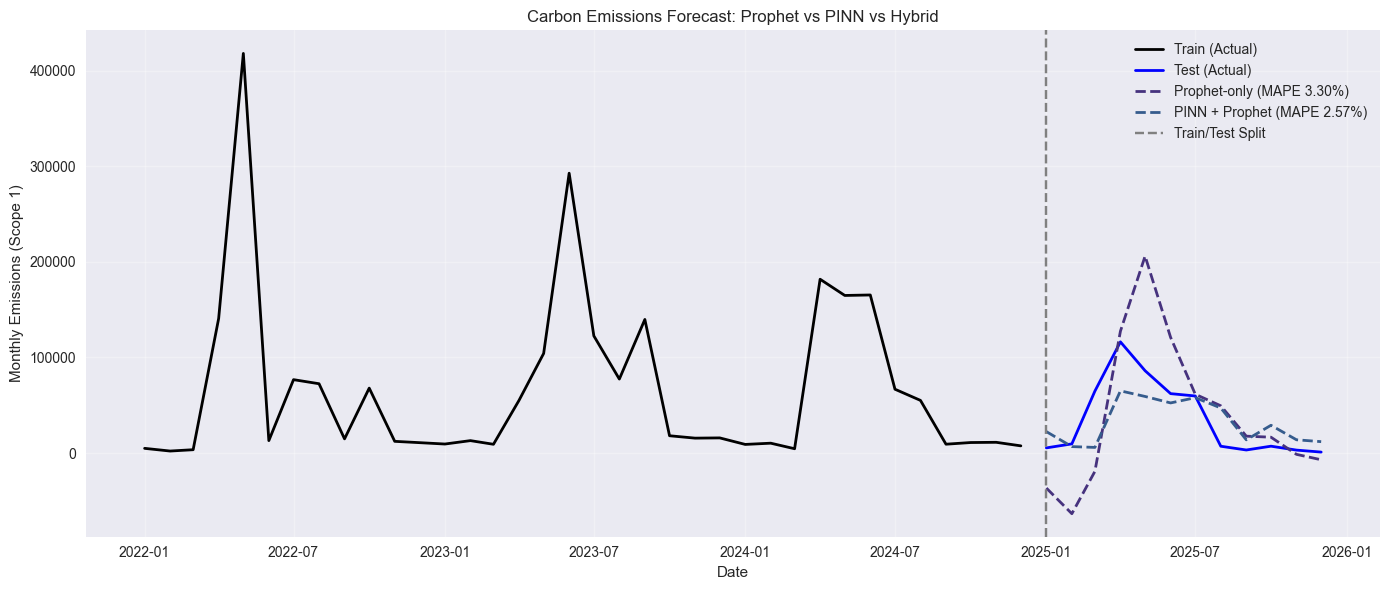

In [86]:
import matplotlib.pyplot as plt

# Collect predictions
predictions = {
    "Prophet-only": y_pred_prophet["yhat"].values if not test_overall.empty else [],
    # "PINN-only": test_overall["pinn_pred"].values if not test_overall.empty else [],
    "PINN + Prophet": test_overall["final_pred"].values if not test_overall.empty else []
}

# Compute MAPEs
results = {
    "Prophet-only": mape_prophet,
    # "PINN-only": mape_pinn,
    "PINN + Prophet": mape_pinn_prophet
}

plt.figure(figsize=(14, 6))

# Training data (actuals)
plt.plot(train_overall["ds"], train_overall["y"], 
         label="Train (Actual)", color="black", linewidth=2)

# Test data (actuals)
plt.plot(test_overall["ds"], test_overall["y"], 
         label="Test (Actual)", color="blue", linewidth=2)

# Forecasts
for name, y_pred in predictions.items():
    if len(y_pred) > 0:  # only plot if available
        plt.plot(test_overall["ds"], y_pred, '--', 
                 label=f"{name} (MAPE {results[name]:.2f}%)", linewidth=2)

# Vertical line for train/test split
if not test_overall.empty:
    split_date = test_overall["ds"].iloc[0]
    plt.axvline(split_date, color="gray", linestyle="--", label="Train/Test Split")

plt.title("Carbon Emissions Forecast: Prophet vs PINN vs Hybrid")
plt.xlabel("Date")
plt.ylabel("Monthly Emissions (Scope 1)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
